In [292]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# Linear Algebraic Methods in Machine Learning

## Support Vector Machines

The main idea behind SVM is that our labeled data might be embedded in a vector space such that each cluster with different labels are separable via a hyperplane.

In this setup, the data we have is a set of pairs $(x^{(i)},y^{(i)})$ where $x^{(i)}\in\mathbb{R}^n$ and $y^{(i)}=
\pm 1$ for every index $i=1,\ldots,N$.

Below, I will sample a random collection of points from $\mathbb{R}^2$ separable by many different hyperplanes.

In [298]:
def randDisk(center,r,N):
    result = []
    x0,y0=center
    for i in range(N):
        r0 = np.random.normal(loc=r,scale=r/2)
        theta = np.random.uniform(0, 2*math.pi)
        result.append([x0+r0*math.cos(theta),y0+r0*math.sin(theta)])
    return result

tmp = randDisk([1,1],0.3,10)
tmp.extend(randDisk([-1,-1],0.3,40))
tmp.extend(randDisk([1,0],0.5,20))
cloud = np.array(tmp)
v = [1,1]
colors = [1 if np.dot(x,v)>0 else -1 for x in cloud]
data = pd.DataFrame({"x": cloud[:,0], "y": cloud[:,1], "class": colors})
data

,x,y,class
0,1.048098,1.159781,1
1,1.103758,0.785483,1
2,1.354968,0.844509,1
3,1.162693,1.201925,1
4,0.929887,1.129516,1
...,...,...,...
65,1.349804,0.390792,1
66,0.423940,-0.282076,1
67,1.757929,0.281667,1
68,1.089217,0.698455,1


Now, look at the picture below. We need a vector $v$ such that the gap between the separating hyperplanes is the largest. Below, the code tries random vectors for the normals of the separating hyperplanes. The correct method is doing a gradient descent algorithm that maximizes the gap that I outlined in the previous lecture.

In [299]:
def findBeta(v,xs,side):
    d = np.array([v[1],-v[0]])
    tmp = [np.dot(x,v) for x in xs]
    if side == -1:
        i = np.argmin(tmp)
    else:
        i = np.argmax(tmp)
    return [xs[i],xs[i]+d]

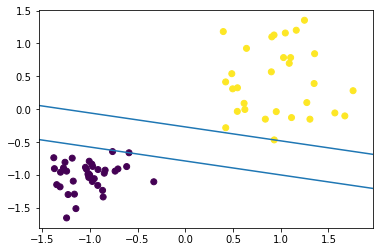

In [302]:
v = randDisk([0,0],1,1)[0]

xs = np.array(data[["x","y"]][data["class"]==1])
ys = np.array(data[["x","y"]][data["class"]==-1])

a,b = findBeta(v,xs,-1)
c,d = findBeta(v,ys,1)

plt.scatter(cloud[:,0],cloud[:,1],c=colors)
plt.axline(a,b)
plt.axline(c,d)

We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$y^{(i)}(x^{(i)}\cdot w - b)\geq 1$ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

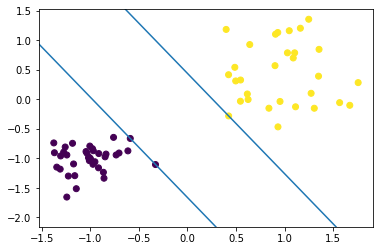

In [303]:
from sklearn.svm import SVC

model = SVC(kernel="linear")
model.fit(data[["x","y"]],data["class"])

v = model.coef_[0]
a,b = findBeta(v,xs,-1)
c,d = findBeta(v,ys,1)
plt.scatter(data["x"],data["y"],c=data["class"])
plt.axline(a,b)
plt.axline(c,d)

### Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin**

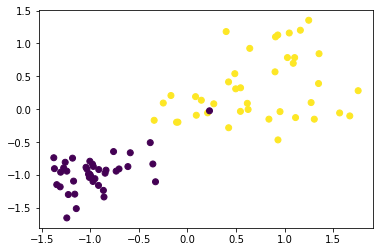

In [304]:
N1 = 10
N2 = 3
cnew = list([1]*N1 + [-1]*N2)
new = randDisk([0.0,0.0],0.2,N1)
new.extend(randDisk([-0.1,-0.5],0.4,N2))
new = np.array(new)

data = data.append(pd.DataFrame({"x": new[:,0], "y": new[:,1], "class": cnew}))
cloud = np.array(data)

plt.scatter(data.x,data.y,c=data["class"])

In these cases instead of minimizing $\|w\|$ subject to 

$ 1 \leq y^{(i)}(x^{(i)}\cdot w - b) $ for all $i=1,\ldots,N$ 

we minimize the **total hinge loss function**
$$ \lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b) $$
where $\lambda$ is a small positive regularization parameter. Changing $\lambda$ controls the degree of mixing of classes inside the margin.  Below, we set $\lambda = 1.0$ by setting `C=1.0`.

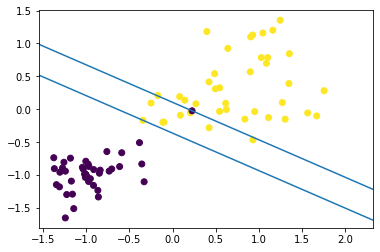

In [305]:
xs = np.array(data[["x","y"]][data["class"]==1])
ys = np.array(data[["x","y"]][data["class"]==-1])

model = SVC(kernel="linear",C=1.0)
model.fit(data[["x","y"]],data["class"])

v = model.coef_[0]
a,b = findBeta(v,xs,-1)
c,d = findBeta(v,ys,1)
plt.scatter(data.x,data.y,c=data["class"])
plt.axline(a,b)
plt.axline(c,d)

### The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

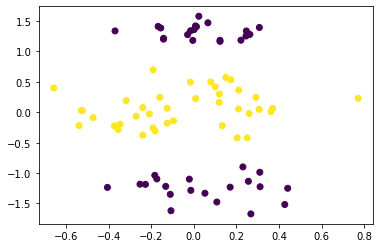

In [306]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))
cloud = np.array(tmp)

colors = [1]*40 + [-1]*40

data = pd.DataFrame({"x" : cloud[:,0], "y": cloud[:,1], "class": colors})
plt.scatter(data["x"],data["y"],c=data["class"])

In [307]:
model = SVC(kernel="rbf",C=1.0)
model.fit(data[["x","y"]],data["class"])

model.score(data[["x","y"]],data["class"])

1.0

## Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

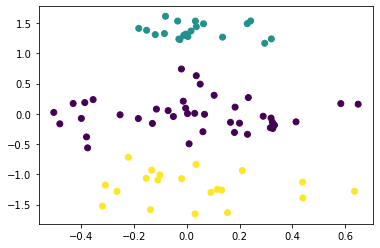

In [308]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))
cloud = np.array(tmp)

colors = [1]*40 + [2]*20 + [3]*20

data = pd.DataFrame({"x" : cloud[:,0], "y": cloud[:,1], "class": colors})
plt.scatter(data["x"],data["y"],c=data["class"])

In [310]:
model = SVC(kernel="linear")
model.fit(data[["x","y"]],data["class"])

model.score(data[["x","y"]],data["class"])

1.0

## Linear Discriminant Analysis (LDA)

Linear discriminant analysis tries to do the same thing as multiclass SVM does: to use linear algebra to separate data according to distinct labels.

As before, we have $(x^{(i)},y^{(i)})$ where each $x^{(i)}\in\mathbb{R}^n$ while each $y^{(i)}$ belongs to a finite set of labels.  Let us write $C^{\alpha}$ for the set of points $x^{(i)}$ for which $y^{(i)}=\alpha$. The main objective LDA tries to accomplish can be summarized as follows:

> Find a projection $\pi\colon \mathbb{R}^n\to \mathbb{R}^m$ where $m$ is much smaller than $n$ such that 
> 1. Each $C^\alpha$ is as compact as possible while
> 2. Each distinct $C^\alpha$ and $C^\beta$ are as separated as possible.

Let us assume each $C^\alpha$ has mean $\mu_\alpha$ and covariance $V_\alpha$. Then **the separation along a direction $w$** is the quantity

$$ S_\alpha(w) = \frac{w^T V_\alpha w}{w^TV w} $$

where $V$ is sum $\sum_\alpha V_\alpha$. What we need then is

$$ argmax_w S_\alpha(w) $$ for each class $\alpha$.

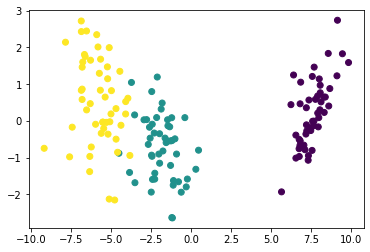

In [464]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris

iris = load_iris()

model = LinearDiscriminantAnalysis()
model.fit(iris.data,iris.target)
transformed = model.fit_transform(iris.data,iris.target)

plt.scatter(transformed[:,0],transformed[:,1],c=iris.target)

Let us look at a larger (real-life) example:

(1797, 64)


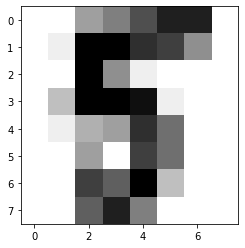

In [375]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.data.shape)
plt.imshow(digits.data[np.random.randint(digits.data.shape[0])].reshape((8,8)),
           cmap='binary', 
           interpolation='nearest')

These are 1797 hand-drawn digits saved as 8x8 image. Let us try to project them onto 2D plane:

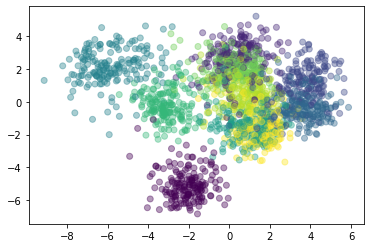

In [466]:
model = LinearDiscriminantAnalysis()
model.fit(digits.data,digits.target)
transformed = model.fit_transform(digits.data,digits.target)

plt.scatter(transformed[:,0],transformed[:,1],c=digits.target,alpha=0.4)

## Principal Component Analysis (PCA)

Unlike SVM and LDA, PCA is an unsupervised method.  As such, in our basic setup we only have data points $x^{(i)}$ and no labels.  Since there is no classification task, what does PCA do?

Now, we may have a large collection of data points $D = \{x^{(i)}\mid i=1,\ldots,N\}$ in some $\mathbb{R}^n$ for some large $n$.  However, it is possible that our data points may not be distributed equally likely in all directions.  For example, consider the following data sets in $\mathbb{R}^2$

In [313]:
def randEllipse(ps,theta0,center,N):
    a,b = ps
    x0,y0 = center
    rot = np.array([[math.cos(theta0),math.sin(theta0)],[-math.sin(theta0),math.cos(theta0)]])
    result = []
    for i in range(N):
        r0 = np.random.normal(loc=1.0,scale=0.5)
        theta = np.random.uniform(0, 2*math.pi)
        point = np.matmul(np.array([x0+a*r0*math.cos(theta),y0+b*r0*math.sin(theta)]),rot)
        result.append(point)
    return result

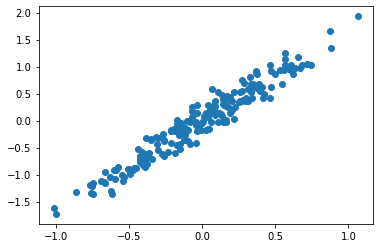

In [337]:
cloud = np.array(randEllipse((0.1,1),-math.pi/6,(0,0),200))
data = pd.DataFrame({"x": cloud[:,0], "y": cloud[:,1]})

plt.scatter(data["x"],data["y"])

As you can see, the data scattered along the line $y=-x$ while the distribution of the data along the line $y=x$ quite tight.

If we consider "x" and "y" coordinates as the features of our dataset, the variations of the data is measured with the eigenvectors of the correlation matrix:

$$ Cor(D) = D^t D $$

[1.97030094 0.02969906]


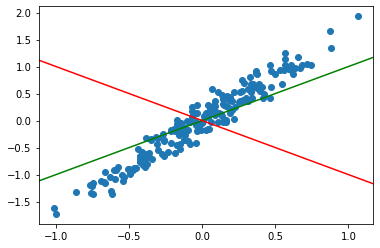

In [338]:
eigvals, eigvectors = np.linalg.eig(data.corr())
print(eigvals)

def perp(xs):
    return [xs[1],-xs[0]]

plt.scatter(data["x"],data["y"])
plt.axline([0,0],perp(eigvectors[0]),c='green')
plt.axline([0,0],eigvectors[0],c='red')

The hyperplane determined by the largest eigenvalue (the green line above) is the direction along which data has the largest variation while along the red line we don't see much variation. This means, if we project the data onto the green line we get the largest variation.  If we project onto the red line the data would look like constant.

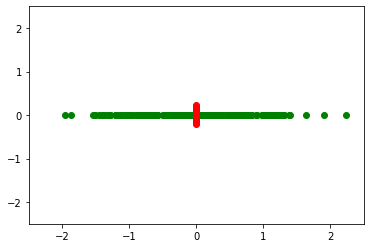

In [354]:
from sklearn.decomposition import PCA

model = PCA()
model.fit(data)

projected = model.fit_transform(data)

plt.xlim((-2.5,2.5))
plt.ylim((-2.5,2.5))
plt.scatter(projected[:,0],np.zeros(len(projected)),c='green')
plt.scatter(np.zeros(len(projected)),projected[:,1],c='red')


Let us transform the hand-drawn digits data using PCA this time:

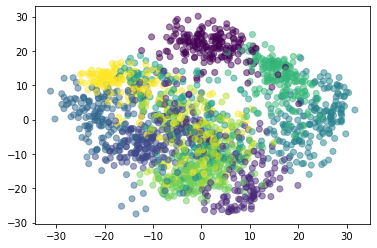

In [369]:
model = PCA(2)
model.fit(digits.data)
cloud = model.fit_transform(digits.data)

plt.figure(size=)
plt.scatter(cloud[:,0],cloud[:,1],c=digits.target, alpha=0.5)

### Olivetti Faces Dataset

In [376]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/kaygun/scikit_learn_data


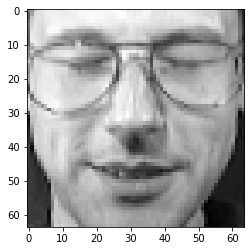

In [388]:
plt.imshow(faces.data[np.random.randint(faces.data.shape[0])].reshape((64,64)),
           cmap='binary_r')

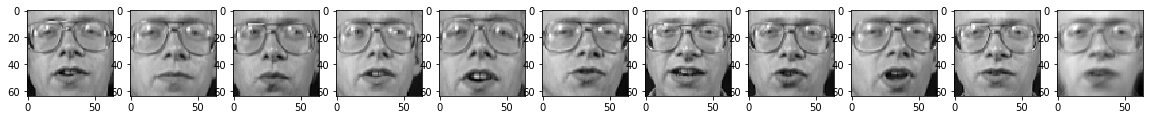

In [452]:
model = PCA(1)
N = np.random.randint(40)
local = faces.data[faces.target==N]

plt.subplots(figsize=(20, 20))

for i in range(10):
    plt.subplot(1,11,i+1)
    plt.imshow(local[i].reshape((64,64)),cmap='binary_r',interpolation='nearest')

xs = local.transpose()
model.fit(xs)
ys = model.fit_transform(xs)
plt.subplot(1,11,11)
plt.imshow(ys.reshape((64,64)),cmap='binary',interpolation='nearest')

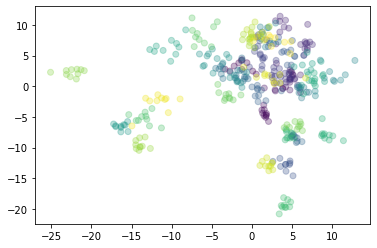

In [468]:
model = LinearDiscriminantAnalysis()

model.fit(faces.data,faces.target)
transformed = model.fit_transform(faces.data,faces.target)

plt.scatter(transformed[:,0],transformed[:,1],c=faces.target, alpha=0.3)